In [1]:
tissue = "nose"

# Census params
meas = "RNA"
layer = "raw"
census = "2024-07-01"
tdb_workers = 1

# Dask params
n_workers = 4
dask_chunk_size = 80_000
threads_per_worker = None
dashboard_port = 8787

In [2]:
from dask.distributed import Client, LocalCluster
from os import cpu_count

if not tdb_workers:
    tdb_workers = cpu_count()

if n_workers is None:
    n_workers = cpu_count() // tdb_workers // threads_per_worker
cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=threads_per_worker,
    dashboard_address=f":{dashboard_port}",
)
print(f"{n_workers=}, {threads_per_worker=}, {tdb_workers=}")
client = Client(cluster)

client

n_workers=4, threads_per_worker=None, tdb_workers=1


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 64,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40955,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:44221,Total threads: 16
Dashboard: http://127.0.0.1:35397/status,Memory: 61.64 GiB
Nanny: tcp://127.0.0.1:37321,


In [3]:
from concurrent.futures import ThreadPoolExecutor
from tiledbsoma import Experiment, SOMATileDBContext

DEFAULT_CONFIG = {
    "vfs.s3.no_sign_request": "true",
    "vfs.s3.region": "us-west-2"
}
CENSUS_S3 = "s3://cellxgene-census-public-us-west-2/cell-census"

species = "homo_sapiens"
soma_uri = f"{CENSUS_S3}/{census}/soma"
exp_uri = f"{soma_uri}/census_data/{species}"

exp = Experiment.open(
    exp_uri,
    context=SOMATileDBContext(
        tiledb_config=DEFAULT_CONFIG,
        threadpool=ThreadPoolExecutor(max_workers=tdb_workers),
    ),
)
exp

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens/obs' (unopened)>

In [5]:
from somacore import AxisQuery

obs_filter = "is_primary_data == True"
if tissue:
    obs_filter = f'tissue_general == "{tissue}" and {obs_filter}'
query = exp.axis_query(
    measurement_name=meas,
    obs_query=AxisQuery(value_filter=obs_filter) if obs_filter else None,
)

In [6]:
%%time
query.n_obs

CPU times: user 940 ms, sys: 1.59 s, total: 2.53 s
Wall time: 651 ms


313887

In [7]:
%%time
adata = query.to_anndata(layer, dask_chunk_size=dask_chunk_size)
adata

CPU times: user 2.28 s, sys: 3.26 s, total: 5.54 s
Wall time: 2.57 s


AnnData object with n_obs × n_vars = 313887 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [8]:
from scanpy.preprocessing._utils import _get_mean_var

In [9]:
%%time
mv0, mv1 = _get_mean_var(adata.X)
mv1

CPU times: user 94.3 ms, sys: 15.3 ms, total: 110 ms
Wall time: 106 ms


dask.array<mul, shape=(60530,), dtype=float64, chunksize=(60530,), chunktype=numpy.ndarray>

In [10]:
mv1.dask

HighLevelGraph with 14 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f5b1df1cfe0>
 0. array-a4019029393bc84cdd72dfadfe9646ca
 1. original-block-info-sparse_chunk-40297af804bdc2aecf35d6833131d14d
 2. block-info-sparse_chunk-40297af804bdc2aecf35d6833131d14d
 3. sparse_chunk-40297af804bdc2aecf35d6833131d14d
 4. sum_drop_keepdims-d364445936ed8738a40167e5136ed13a
 5. aggregate_sum-aggregate-bdbf7f03722b61ad5476f8efb00bef4f
 6. truediv-0a24f2af3565cf6cf2cfd2947cf1a79f
 7. pow-b57011d040da9106cb8e9acb7adf894c
 8. elem_mul-e23cb153dbab0285d29cf4e01fc3fabc
 9. sum_drop_keepdims-b0cf34a6155fd8b4109dfd2ce782ffd5
 10. aggregate_sum-aggregate-2fa9285e720fb661471bb0aa645d88e5
 11. truediv-edfb01723d108b6f4d80f928f5ed437f
 12. sub-ee56f285553d043ef47a0b5e68e8759d
 13. mul-9e7f9028f64879e6d99fd2dfcb86027b

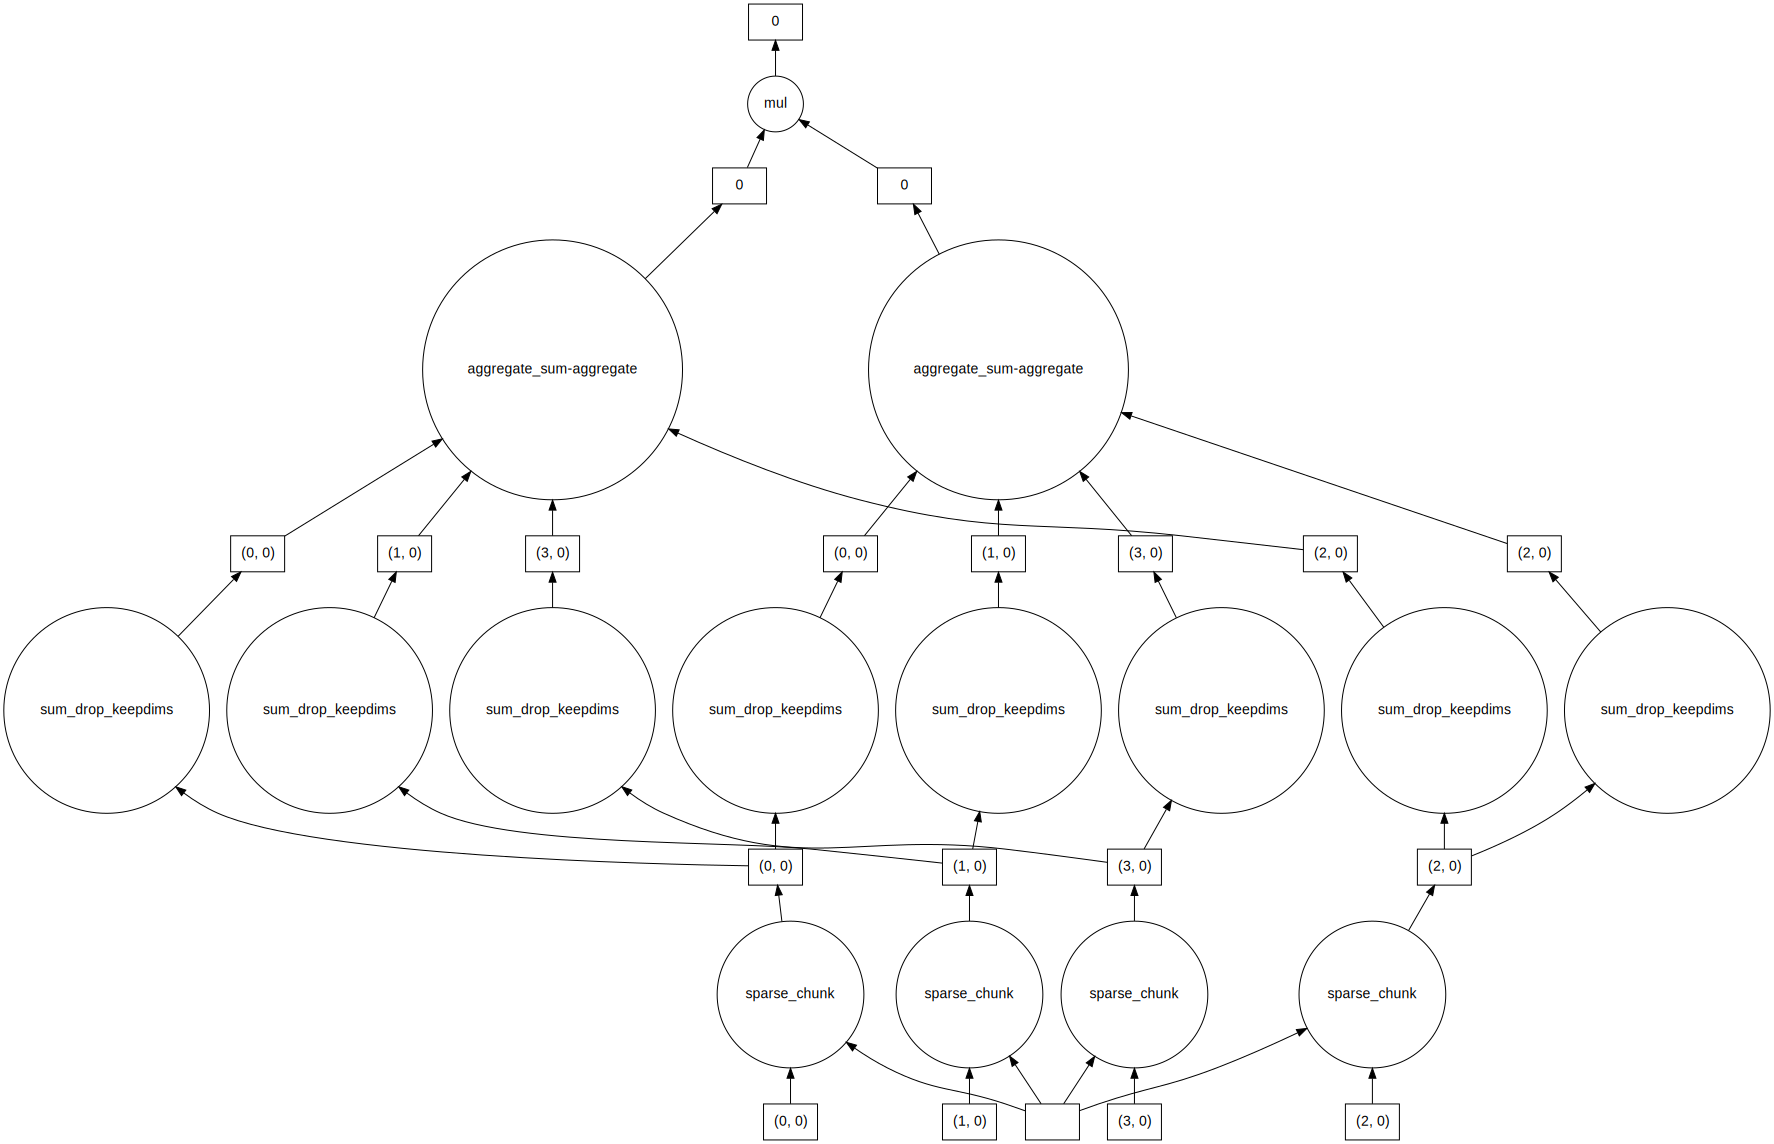

In [11]:
mv1.visualize(f'mean-var-{tissue}-tdbs.opt.svg', optimize_graph=True)

In [12]:
%%time
mv1c = mv1.compute()
mv1c

CPU times: user 7.68 s, sys: 1.18 s, total: 8.86 s
Wall time: 1min 45s


array([2.37486496e+00, 1.78383347e-04, 2.47206989e-01, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])